## Contents

#### 1. Finite Difference Gradient
#### 2. Analytics Gradient
#### 3. Quantum Natural Gradient
#### 4. Quantum Natural Gradient Versus Analytic Gradient 

In [11]:
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_algorithms.gradients import LinCombEstimatorGradient
from qiskit_algorithms.optimizers import GradientDescent
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import SPSA
from qiskit.quantum_info import Pauli
from matplotlib import pyplot as plt
import numpy as np

#### Ansatz

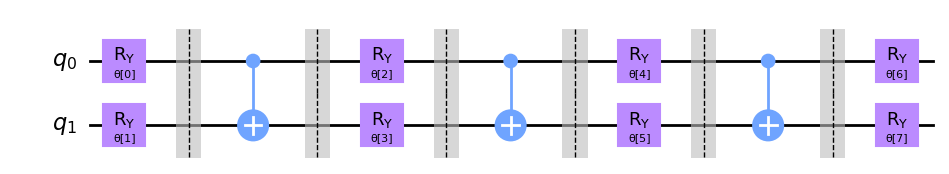

In [2]:
ansatz = RealAmplitudes(num_qubits = 2, entanglement = 'linear', insert_barriers = True).decompose()
EPS = 0.2   # Epsilon value
param_values = np.random.rand(ansatz.num_parameters)   # randomly generating parameters' values
ansatz.draw('mpl')

#### Hamiltonian

In [3]:
Z = Pauli('Z')   # Pauli Z operator
hamiltonian = Z ^ Z

In [4]:
## Estimator

estimator = Estimator()

## Finite difference gradient

Circuit parameters: [ 0.6860885  -0.4089014  -0.05408193 -0.31469458  0.685243   -0.79008489
  0.09806448  0.09459265]


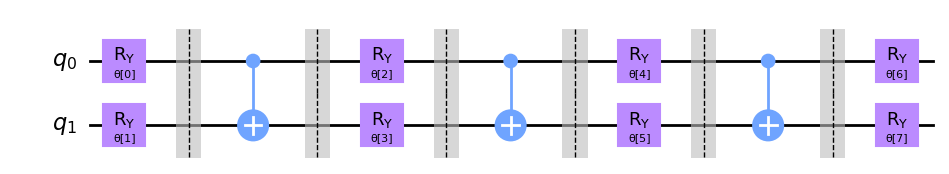

In [5]:
gradient = FiniteDiffEstimatorGradient(estimator, EPS)

gradients = gradient.run(ansatz, hamiltonian, [param_values]).result().gradients[0]

print(f'Circuit parameters:', gradients)

ansatz.draw(output = 'mpl')

## Objective function or Expectation Value

In [6]:
def expectation(ansatz, hamiltonian, estimator):
    def eval_expectation(param_values):
        bound_ansatz = ansatz.bind_parameters(dict(zip(ansatz.parameters, param_values)))
        expectation_value = estimator.run(bound_ansatz, hamiltonian).result().values[0]
        return expectation_value
    return eval_expectation

# Analytic Gradient Descent

* it basically uses parameter shift rules

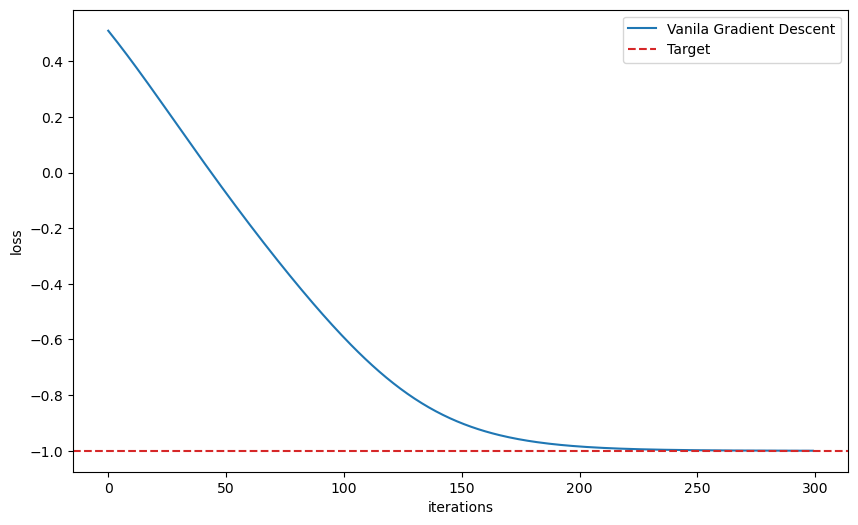

In [21]:
def gradient(estimator, ansatz, hamiltonian):
    def eval_gradient(param_values):
        gradient = ParamShiftEstimatorGradient(estimator)
        gradients = gradient.run(ansatz, hamiltonian, parameter_values = [param_values]).result().gradients[0]
        return gradients
    return eval_gradient


class OptimizerLog:
    'Log to store intermediate results of Optimizer'
    def __init__(self):
        self.loss = []
    
    def update(self,  _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

gd_log = OptimizerLog()
gd = GradientDescent(maxiter = 300, 
                     learning_rate = 0.01, 
                     callback = gd_log.update)

result = gd.minimize(fun = expectation(ansatz, hamiltonian, estimator), #function to minimize
                     x0 = param_values,   #Initial Points
                     jac = gradient(estimator, ansatz, hamiltonian)
                    )

'Ploting the curves'
plt.figure(figsize = (10, 6))
plt.plot(gd_log.loss, label = 'Vanila Gradient Descent')
plt.axhline(-1, ls = '--', c = 'C3', label = 'Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

# ansatz.draw(output = 'mpl')

# Quantum natural Gradient

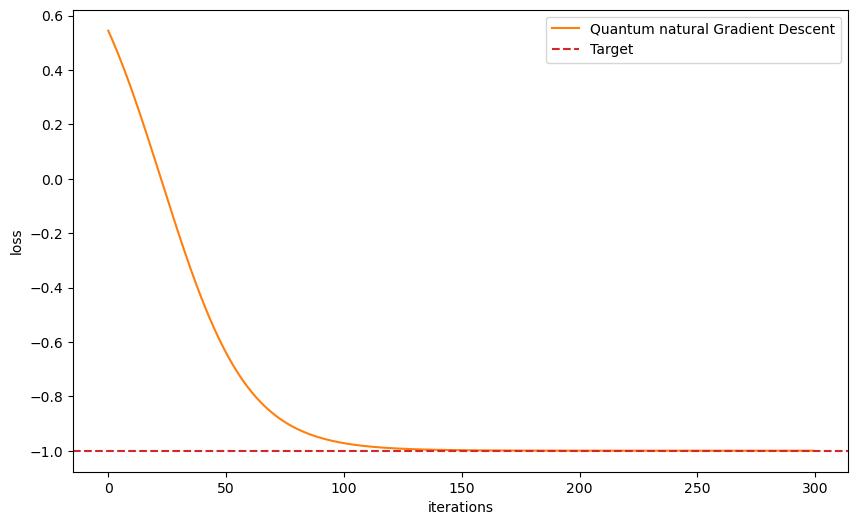

In [8]:
estimator = Estimator()

def expectation(ansatz, estimator, hamiltonian):
    def eval_expectation(param_values):
        ansatz_bound = ansatz.bind_parameters(dict(zip(ansatz.parameters, param_values)))
        expectation_value = estimator.run(ansatz_bound, hamiltonian).result().values[0]
        return expectation_value
    
    return eval_expectation

def eval_gradient(ansatz, estimator, hamiltonian):
    def gradient(param_values):
        gradient = LinCombEstimatorGradient(estimator)
        gradients = gradient.run(ansatz, hamiltonian, parameter_values = [param_values]).result().gradients[0]
        return gradients

    return gradient
        
class OptimizerLog1:
    'Log to store intermediate results of Optimizer'
    def __init__(self):
        self.loss = []
    
    def update(self,  _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

qgd_log = OptimizerLog1()
from qiskit_algorithms.optimizers import GradientDescent
qgd = GradientDescent(maxiter = 300, learning_rate = 0.01, callback = qgd_log.update)

result = qgd.minimize(fun = expectation(ansatz, estimator, hamiltonian),
                      x0 = param_values,
                      jac = eval_gradient(ansatz, estimator, hamiltonian))

'Ploting the curves'
plt.figure(figsize = (10, 6))
plt.plot(qgd_log.loss, 'C1', label = 'Quantum natural Gradient Descent')
plt.axhline(-1, ls = '--', c = 'C3', label = 'Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

# ansatz.draw(output = 'mpl')

## Quantum natural Gradient Versus Analytics gradient

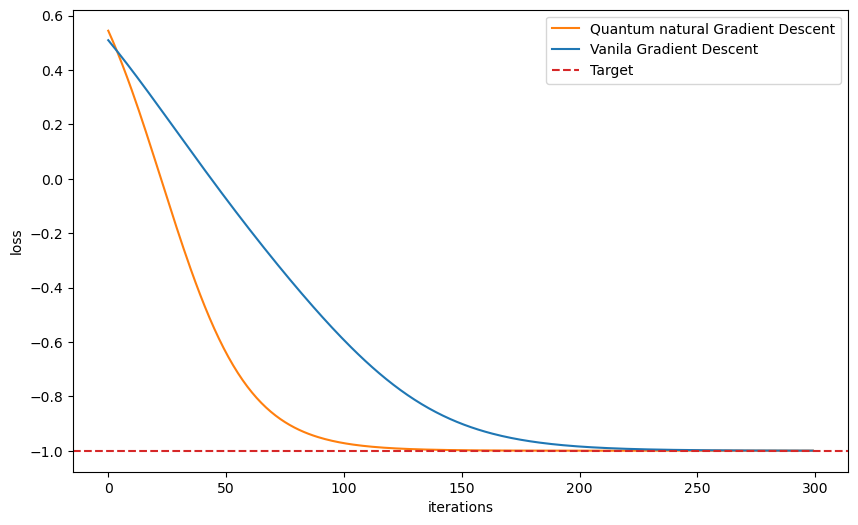

In [22]:
'Ploting the curves'
plt.figure(figsize = (10, 6))
plt.plot(qgd_log.loss, 'C1', label = 'Quantum natural Gradient Descent')
plt.plot(gd_log.loss, label = 'Vanila Gradient Descent')
plt.axhline(-1, ls = '--', c = 'C3', label = 'Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

## Simultaneous Perturbation Stochastic Approximation

* Simultaneous Perturbation Approximation (SPSA) is an optimization technique where we randomly sample from the gradient, to reduce the number of evaluations. Since we don't care about the exact values but only about convergence, an unbiased sampling should on average work equally well.

In [13]:
ansatz = RealAmplitudes(num_qubits = 2, entanglement = 'linear', insert_barriers = True).decompose()
param_values =np.random.rand(ansatz.num_parameters)

param_values = np.random.rand(ansatz.num_parameters)
estimator = Estimator()

def expectation(ansatz, hamiltonian, estimator):
    def eval_expectation(param_values):
        ansatz_bound = ansatz.bind_parameters(dict(zip(ansatz.parameters, param_values)))
        expectation_value = estimator.run(ansatz_bound, hamiltonian).result().values[0]                                                                     
        return expectation_value
    return eval_expectation

def eval_gradient(estimator, ansatz, hamiltonian):
    def gradient(param_values):
        gradient = ParamShiftEstimatorGradient(estimator)
        gradients = gradient.run(ansatz, hamiltonian, parameter_values=[param_values]).result().gradients[0]
        return gradients
    return gradient

class OptimizerLog:
    'Log to store intermediate results of Optimizer'
    def __init__(self):
        self.loss = []
        self.best_params_list = []  # Store all the best parameters
    
    def update(self,  _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third."""
        self.loss.append(ftheta)
        
        # Update best solution if the current one is better
        if not self.best_params_list or np.min(ftheta) < np.min(self.loss):
            self.best_params_list.append(np.copy(_theta))  # Copy the parameters to avoid issues with mutable objects
    
    def get_best_solutions(self):
        return self.best_params_list
    
gd_log = OptimizerLog()

from qiskit_algorithms.optimizers import GradientDescent
gd = GradientDescent(maxiter = 300, 
                     learning_rate = 0.01, 
                     callback = gd_log.update)


spsa_log = OptimizerLog()

# Run SPSA optimization
spsa = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.01, callback=spsa_log.update)
result = spsa.minimize(eval_gradient(estimator, ansatz, hamiltonian), param_values)

# Get all the best solutions
best_params_list = spsa_log.get_best_solutions()

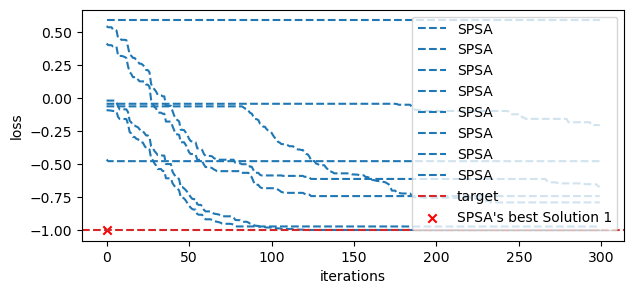

In [14]:
# Plot the best solutions
plt.figure(figsize=(7, 3))
plt.plot(np.minimum.accumulate(spsa_log.loss), 'C0', ls='--', label='SPSA')  # Use np.minimum.accumulate to get the minimum so far
plt.axhline(-1, c='C3', ls='--', label='target')

# Scatter plot for all the best solutions
for i, best_params in enumerate(best_params_list):
    plt.scatter(i, np.min(spsa_log.loss), marker='x', c='red', label=f"SPSA's best Solution {i + 1}")

plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

### Comparing Analytic, Quantum Natural, and SPSA Gradients

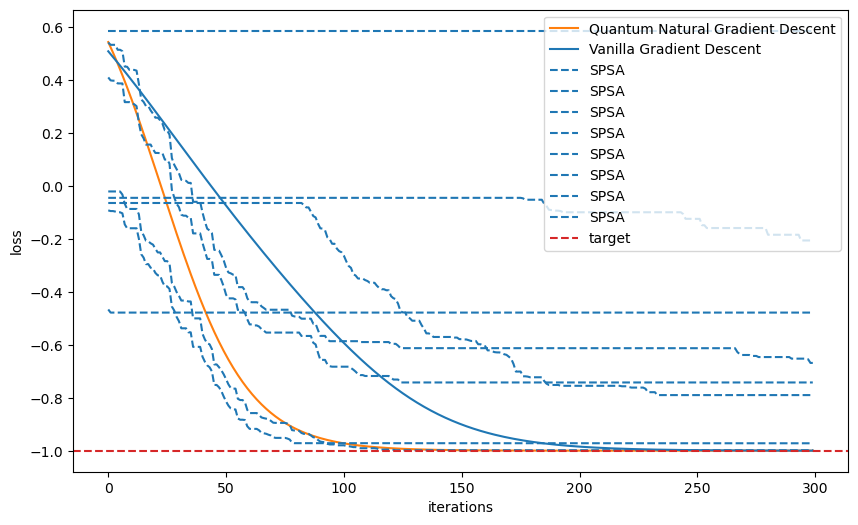

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(qgd_log.loss, 'C1', label='Quantum Natural Gradient Descent')
plt.plot(gd_log.loss, label='Vanilla Gradient Descent')
plt.plot(np.minimum.accumulate(spsa_log.loss), 'C0', ls='--', label='SPSA')  # Use np.minimum.accumulate to get the minimum so far
plt.axhline(-1, c='C3', ls='--', label='target')

plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()